<a href="https://colab.research.google.com/github/rider110/Notebooks/blob/main/CatsAndDogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import pathlib
from typing import Tuple, Dict, List

import pandas as pd
import numpy as np

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torchvision.models as models

In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Data loading and Preparation

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "cats_and_dogs"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "cats_and_dogs.zip", "wb") as f:
        request = requests.get("https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
        print("Downloading cats and dogs data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "cats_and_dogs.zip", "r") as zip_ref:
        print("Unzipping cats and dogs data...") 
        zip_ref.extractall(image_path)

Did not find data/cats_and_dogs directory, creating one...
Unzipping cats and dogs data...


In [ ]:
!pip install split-folders
import splitfolders

splitfolders.ratio("/content/data/cats_and_dogs/PetImages", output="output",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 25002 files [00:05, 4679.49 files/s]


In [ ]:
# Setup train and testing paths
data_dir = Path("output/")
train_dir = data_dir / 'train'
val_dir = data_dir / 'val'
#test_dir = data_dir / 'test'

train_dir, val_dir

(PosixPath('output/train'), PosixPath('output/val'))

In [ ]:
filenames = os.listdir("/content/output/train/")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
df

,filename,category
0,Dog,0
1,Cat,0


# Visualising Images

Random image path: data/cats_and_dogs/PetImages/Cat/4318.jpg
Image class: Cat
Image height: 332
Image width: 432


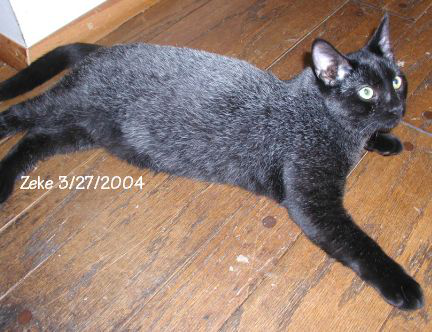

In [ ]:
import os
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

In [ ]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Crearte a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [ ]:
find_classes(train_dir)

(['Cat', 'Dog'], {'Cat': 0, 'Dog': 1})

#Dataset and Dataloaders

In [ ]:
# Write transform for image
train_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(128, 128)),
    # apply color distortions
    transforms.ColorJitter(brightness=0.7, saturation=0.8),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    transforms.Grayscale(3),
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

# Write transform for image
val_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(128, 128)),
    transforms.Grayscale(3),
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

In [ ]:
train_data = datasets.ImageFolder(
                              root = train_dir,
                              transform = train_transform
                       )
val_data = datasets.ImageFolder(
                              root = val_dir,
                              transform = train_transform
                       )
print(train_data)
print(val_data)

Dataset ImageFolder
    Number of datapoints: 19998
    Root location: output/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
               ColorJitter(brightness=[0.30000000000000004, 1.7], contrast=None, saturation=[0.19999999999999996, 1.8], hue=None)
               RandomHorizontalFlip(p=0.5)
               Grayscale(num_output_channels=3)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 5002
    Root location: output/val
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
               ColorJitter(brightness=[0.30000000000000004, 1.7], contrast=None, saturation=[0.19999999999999996, 1.8], hue=None)
               RandomHorizontalFlip(p=0.5)
               Grayscale(num_output_channels=3)
               ToTensor()
           )


In [ ]:
train_data.class_to_idx

{'Cat': 0, 'Dog': 1}

In [ ]:
idx2class = {v: k for k, v in train_data.class_to_idx.items()}
idx2class

{0: 'Cat', 1: 'Dog'}

In [ ]:
from torch.utils.data import DataLoader

# Training DataLoader
train_dl = DataLoader(train_data,
                      batch_size=32, 
                      shuffle=True)

# Validation DataLoader
val_dl = DataLoader(val_data,
                    batch_size=32,
                    shuffle=False)

# Defining CNN

In [ ]:
#CNN
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input  [1, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128), 
            nn.ReLU(), 
            nn.Linear(128,2)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

In [ ]:
from torch.optim import Adam

#setting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
# print(device)
model = Classifier().to(device)
 
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [ ]:
import time
import numpy as np

# model.train()
# when 40 epochs acc reach 94-95% 
#epochs setting 1 just for run 
epochs = 1
for epoch in range(epochs):
    epoch_start_time = time.time()
    train_acc =0.0
    val_acc =0.0
    train_loss = 0.0
    val_loss =0.0
    model.train()
    for i,data in enumerate(train_dl):
        optimizer.zero_grad()
        x,y = data[0].to(device),data[1].to(device)
        # print(x.shape)
        y_pred = model(x)
        loss = loss_fn(y_pred,y.long())
        loss.backward()
        optimizer.step()
        train_acc +=np.sum(np.argmax(y_pred.cpu().data.numpy(),axis=1)== y.cpu().numpy())
        train_loss +=loss.item()
    model.eval()
    with torch.no_grad():
        for i,data in enumerate(val_dl):
            valx ,valy = data[0].to(device),data[1].to(device)
            val_pred = model(valx)
            batch_loss = loss_fn(val_pred,valy.long())
            val_acc +=np.sum(np.argmax(val_pred.cpu().data.numpy(),axis=1)== valy.cpu().numpy())
            val_loss +=batch_loss.item()

        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, epochs, time.time()-epoch_start_time, \
             train_acc/train_data.__len__(), train_loss/train_data.__len__(), val_acc/val_data.__len__(), val_loss/val_data.__len__()))